# Acrobot-v1 - Tile Coding
https://gym.openai.com/envs/Acrobot-v1/
The acrobot system includes two joints and two links, where the joint between the two links is actuated. Initially, the links are hanging downwards, and the goal is to swing the end of the lower link up to a given height.

Acrobot is a 2-link pendulum with only the second joint actuated. Initially, both links point downwards. The goal is to swing the end-effector at a height at least the length of one link above the base. Both links can swing freely and can pass by each other, i.e., they don't collide when they have the same angle.

**STATE:**<br>
The state consists of the sin() and cos() of the two rotational joint angles and the joint angular velocities :
* [cos(theta1) sin(theta1) cos(theta2) sin(theta2) thetaDot1 thetaDot2].

For the first link, an angle of 0 corresponds to the link pointing downwards. The angle of the second link is relative to the angle of the first link. An angle of 0 corresponds to having the same angle between the two links.

A state of [1, 0, 1, 0, ..., ...] means that both links point downwards.

**ACTIONS:**<br>
* The action is either applying +1, 0 or -1 torque on the joint between the two pendulum links.

<img src='http://projects.rajivshah.com/images/training.gif' width="200" height="200">

In [1]:
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=80)

In [2]:
env = gym.make('Acrobot-v1')
env.seed(505)

print('State Space \t', env.observation_space)
print('  Low \t\t', env.observation_space.low)
print('  High \t\t', env.observation_space.high)

print('Action Space \t', env.action_space)

print('Sample \t\t', env.observation_space.sample())

State Space 	 Box(6,)
  Low 		 [ -1.     -1.     -1.     -1.    -12.566 -28.274]
  High 		 [ 1.     1.     1.     1.    12.566 28.274]
Action Space 	 Discrete(3)
Sample 		 [-0.106 -0.214  0.516 -0.067 10.716  4.714]


In [3]:
def create_tiling_grid(low, high, bins=(10,10), offsets=(0.0,0.0)):
    grid = []
    for dim in range(len(bins)):
        l = low[dim]
        h = high[dim]
        b = bins[dim]
        os = offsets[dim]
        g = np.linspace(l, h, b+1)[1:-1] + os
        grid.append(g)
    return grid

low = [-1.0, -5.0]
high = [1.0, 5.0]

create_tiling_grid(low, high, bins=(10,10), offsets=(-0.1, 0.5))

[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]

In [4]:
def create_tilings(low, high, tiling_specs):
    grid = []
    for bins, offsets in tiling_specs:
        g = create_tiling_grid(low, high, bins, offsets)
        grid.append(g)
    return grid

low = [-1.0, -5.0]
high = [1.0, 5.0]
bins = (10, 10)
offsets = [(-0.066, -0.33), (0.0, 0.0), (0.066, 0.33)]

tiling_specs = [(bins, os) for os in offsets]
print(tiling_specs)
tilings = create_tilings(low, high, tiling_specs)
tilings

[((10, 10), (-0.066, -0.33)), ((10, 10), (0.0, 0.0)), ((10, 10), (0.066, 0.33))]


[[array([-0.866, -0.666, -0.466, -0.266, -0.066,  0.134,  0.334,  0.534,  0.734]),
  array([-4.33, -3.33, -2.33, -1.33, -0.33,  0.67,  1.67,  2.67,  3.67])],
 [array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
  array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])],
 [array([-0.734, -0.534, -0.334, -0.134,  0.066,  0.266,  0.466,  0.666,  0.866]),
  array([-3.67, -2.67, -1.67, -0.67,  0.33,  1.33,  2.33,  3.33,  4.33])]]

## Visualize Grid

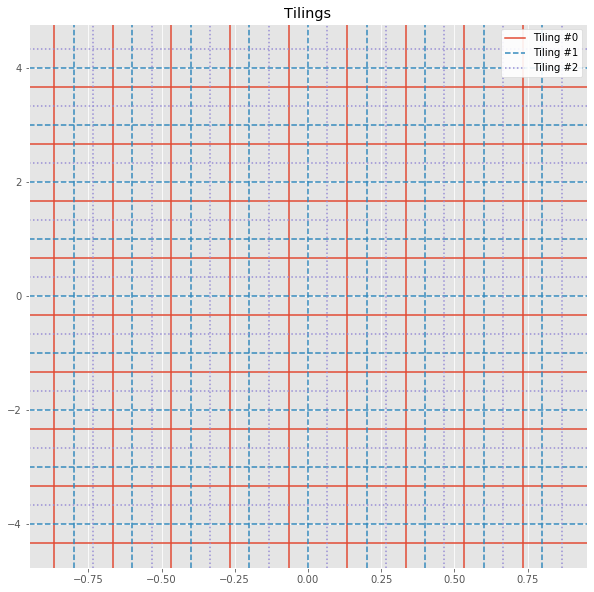

In [5]:
from matplotlib.lines import Line2D

# Plot each tiling as a grid
def visualize_tilings(tilings):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyles = ['-', '--', ':']
    legend_lines = []
    legends = []
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    for i, grid in enumerate(tilings):
        cl = colors[i % len(colors)]
        ls = linestyles[i % len(linestyles)]
        lbl = i
        lgnd = 'Tiling #{}'.format(i)
        
        for x, y in zip(grid[0], grid[1]):
            l = ax.axvline(x=x, color=cl, linestyle=ls, label=lbl)
            l = ax.axhline(y=y, color=cl, linestyle=ls, label=lbl)
            
        legend_lines.append(l)
        legends.append(lgnd)
        
    ax.grid('off')
    ax.set_title('Tilings')

    ax.legend(legend_lines, legends, facecolor='white', framealpha=0.9)
    return ax

visualize_tilings(tilings);

## Tile Encoding
Continuous state value to a discrete vector

In [6]:
# Discretize a sample as per given grid
def discretize(sample, grid):
    tup = []
    for s, g in zip(sample, grid):
        t = int(np.digitize(s, g))
        tup.append(t)
    return tuple(tup)

def tile_encode(sample, tilings, flatten=False):
    encoded_sample = [discretize(sample, grid) for grid in tilings]
    if flatten:
        encoded_sample = np.concatenate(encoded_sample)
    return encoded_sample


In [7]:
# Test with some sample values
samples = [(-1.2 , -5.1 ),
           (-0.75,  3.25),
           (-0.5 ,  0.0 ),
           ( 0.25, -1.9 ),
           ( 0.15, -1.75),
           ( 0.75,  2.5 ),
           ( 0.7 , -3.7 ),
           ( 1.0 ,  5.0 )]

In [8]:
encoded_samples = [tile_encode(sample, tilings, flatten=True) for sample in samples]

print('Encoded Samples: ', repr(encoded_samples), sep='\n')

Encoded Samples: 
[array([0, 0, 0, 0, 0, 0]), array([1, 8, 1, 8, 0, 7]), array([2, 5, 2, 5, 2, 4]), array([6, 3, 6, 3, 5, 2]), array([6, 3, 5, 3, 5, 2]), array([9, 7, 8, 7, 8, 7]), array([8, 1, 8, 1, 8, 0]), array([9, 9, 9, 9, 9, 9])]


In [9]:
encoded_samples = [tile_encode(sample, tilings) for sample in samples]

print('Samples: ', repr(samples), sep='\n')
print('\nEncoded Samples: ', repr(encoded_samples), sep='\n')
print(len(encoded_samples))

Samples: 
[(-1.2, -5.1), (-0.75, 3.25), (-0.5, 0.0), (0.25, -1.9), (0.15, -1.75), (0.75, 2.5), (0.7, -3.7), (1.0, 5.0)]

Encoded Samples: 
[[(0, 0), (0, 0), (0, 0)], [(1, 8), (1, 8), (0, 7)], [(2, 5), (2, 5), (2, 4)], [(6, 3), (6, 3), (5, 2)], [(6, 3), (5, 3), (5, 2)], [(9, 7), (8, 7), (8, 7)], [(8, 1), (8, 1), (8, 0)], [(9, 9), (9, 9), (9, 9)]]
8


## Visualize Encoded Samples

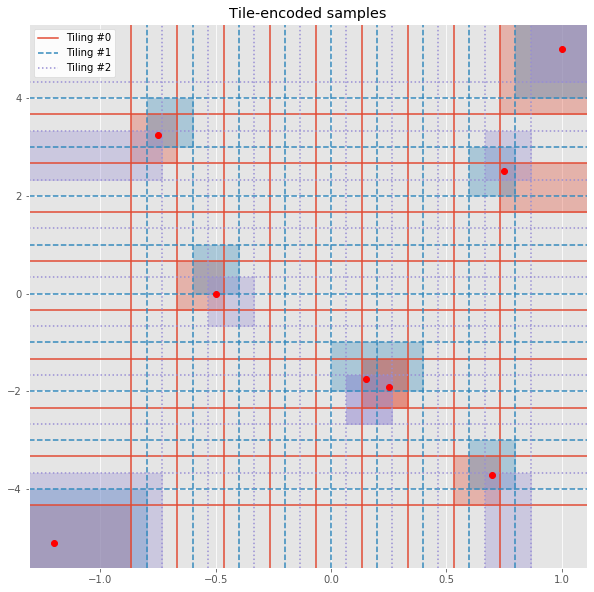

In [10]:
from matplotlib.patches import Rectangle

# Visualize samples by activating the respective tiles
def visualize_encoded_samples(samples, encoded_samples, tilings, low=None, high=None):
    samples = np.array(samples)
    ax = visualize_tilings(tilings)
    
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        xs = samples[:, 0]
        ys = samples[:, 1]
        # Pre-render (invisible) samples to automatically set reasonable axis limits, and use them as (low, high)
        ax.plot(xs, ys, 'o', alpha=0.0)
        low = [ax.get_xlim()[0], ax.get_ylim()[0]]
        high = [ax.get_xlim()[1], ax.get_ylim()[1]]
    
    # Map each encoded sample (which is really a list of indices) to the corresponding tiles it belongs to
    tilings_extended = []
    for grid in tilings:
        bgn = np.array([low]).T
        end = np.array([high]).T
        h = np.hstack((bgn, grid, end))
        tilings_extended.append(h)
        
    tile_centers = []
    tile_toplefts = []
    tile_bottonrights = []
    for grid_extended in tilings_extended:
        tc = (grid_extended[:, :-1] + grid_extended[:, 1:]) / 2
        ttl = grid_extended[:, :-1]
        tbr = grid_extended[:, 1:]
        
        tile_centers.append(tc)
        tile_toplefts.append(ttl)
        tile_bottonrights.append(tbr)
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    for sample, encoded_sample in zip(samples, encoded_samples):
        for i, tile in enumerate(encoded_sample):
            t0, t1 = tile[0], tile[1]
            tl = tile_toplefts[i][0][t0], tile_toplefts[i][1][t1] # topleft
            br = tile_bottonrights[i][0][t0], tile_bottonrights[i][1][t1] # bottomright
            
            rect = Rectangle(tl, br[0] - tl[0], br[1] - tl[1], color=colors[i], alpha=0.33)
            ax.add_patch(rect)
            
            # In case sample is outside tile bounds, it may not have been highlighted properly
            if any(sample < tl) or any(sample > br):
                # plot a point in the center of the tile and draw a connecting line
                t0, t1 = tile[0], tile[1]
                cx, cy = tile_centers[i][0][t0], tile_centers[i][1][t1]
                ln = Line2D([sample[0], cx], [sample[1], cy], color=colors[i])
                ax.add_line(ln)
                ax.plot(cx, cy, 's', color=colors[i])
                
     # Finally, plot original samples
    ax.plot(samples[:, 0], samples[:, 1], 'o', color='r')
    ax.margins(x=0, y=0)
    ax.set_title("Tile-encoded samples")       
            
visualize_encoded_samples(samples, encoded_samples, tilings)

## Q-Table with Tile Coding

In [11]:
# Simple Q-table
class QTable:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        shape = (self.state_size + (self.action_size,))
        
        self.q_table = np.zeros(shape=shape)
        print('QTable(): size = ', self.q_table.shape)

In [12]:
# Composite Q-table with an internal tile coding scheme
class TiledQTable:
    def __init__(self, low, high, tiling_specs, action_size):
        self.tilings = create_tilings(low, high, tiling_specs)
        
        self.state_sizes = []
        for tiling_grid in self.tilings: # three tiling grids
            shape = []
            for splits in tiling_grid:
                shape.append(len(splits) + 1)
            shape = tuple(shape)
            self.state_sizes.append(shape) 
            
        self.action_size = action_size
        
        self.q_tables = []
        for state_size in self.state_sizes:
            qt = QTable(state_size, self.action_size)
            self.q_tables.append(qt)
        print("TiledQTable(): no. of internal tables = ", len(self.q_tables))
        
    
    def get(self, state, action):
        
        encoded_state = tile_encode(state, self.tilings)
        
        value = 0.0
        for idx, q_table in zip(encoded_state, self.q_tables):
            tup = tuple(idx + (action, ))
            val = q_table.q_table[tup]
            value += val
        value /= len(self.q_tables)
        return value
    
    def update(self, state, action, value, alpha=0.1):
        
        encoded_state = tile_encode(state, self.tilings)
        
        # Update q-value for each tiling by update factor alpha
        for idx, q_table in zip(encoded_state, self.q_tables):
            tup = tuple(idx + (action, ))
            q_table.q_table[tup] = (1.0 - alpha) * q_table.q_table[tup] + alpha * value
            


# Test with a sample Q-table
tq = TiledQTable(low, high, tiling_specs, 2)

s1 = 3; s2 = 4; a = 0; q = 1.0

sam = samples[s1]
print()
print(sam, '->' ,encoded_samples[s1])
print('[GET]\t\t Q({}, {}) = {}'.format(sam, a, tq.get(sam, a))) # check value at sample = s1, action = a
print()

sam = samples[s2]
print(sam, '->' ,encoded_samples[s2])
print('[UPDATE]\t Q({}, {}) = {}'.format(sam, a, q)) # update value for sample with some common tile(s)
tq.update(sam, a, q)

print()
# check value again, should be slightly updated
sam = samples[s1]
print(sam, '->' ,encoded_samples[s1])
print('[GET]\t\t Q({}, {}) = {}'.format(sam, a, tq.get(sam, a))) # check value at sample = s1, action = a

QTable(): size =  (10, 10, 2)
QTable(): size =  (10, 10, 2)
QTable(): size =  (10, 10, 2)
TiledQTable(): no. of internal tables =  3

(0.25, -1.9) -> [(6, 3), (6, 3), (5, 2)]
[GET]		 Q((0.25, -1.9), 0) = 0.0

(0.15, -1.75) -> [(6, 3), (5, 3), (5, 2)]
[UPDATE]	 Q((0.15, -1.75), 0) = 1.0

(0.25, -1.9) -> [(6, 3), (6, 3), (5, 2)]
[GET]		 Q((0.25, -1.9), 0) = 0.06666666666666667


## Implement a Q-Learning Agent using Tile-Coding

In [13]:
# Q-Learning agent that can act on a continuous state space by discretizing it
class QLearningAgent:
    def __init__(self, env, tq, alpha=0.02, gamma=0.99, 
                 epsilon=1.0, epsilon_decay_rate=0.9995, min_epsilon=0.01, seed=0):
        self.env = env
        self.tq = tq
        self.state_sizes = tq.state_sizes
        self.action_size = self.env.action_space.n
        self.seed = np.random.seed(seed)
        print()
        print('Environment: ', self.env)
        print('State space sizes: ', self.state_sizes)
        print('Action space sizes: ', self.action_size)
        
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = self.initial_epsilon = epsilon
        self.epsilon_decay_rate = epsilon_decay_rate
        self.min_epsilon = min_epsilon
        
    def reset_episode(self, state):
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)
        
        self.last_state = state
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        self.last_action = np.argmax(Q_s)
        return self.last_action
        
    def reset_exploration(self, epsilon=None):
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon
    
    # Pick next action and update internal Q table during train
    def act(self, state, reward=None, done=None, mode='train'):
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        
        greedy_action = np.argmax(Q_s)
        if mode == 'test':
            action = greedy_action
        else:
            value = reward + self.gamma * max(Q_s)
            self.tq.update(self.last_state, self.last_action, value, self.alpha)
            
            # exploration vs exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            
            if do_exploration:
                action = np.random.randint(0, self.action_size)
            else:
                action = greedy_action
        
        self.last_state = state
        self.last_action = action
        return action
    
    
print('env.observation_space.shape ', env.observation_space.shape, end='\n\n')

n_bins = 5
bins = tuple([n_bins] * env.observation_space.shape[0])
print('bins:\t\t', bins, end='\n\n')

offset_pos = (env.observation_space.high - env.observation_space.low) / (3 * n_bins)
print('offset_pos\t',offset_pos, end='\n\n')

tiling_specs = [
    (bins, -offset_pos),
    (bins, tuple([0.0] * env.observation_space.shape[0])),
    (bins, offset_pos)
]

print('tiling_specs', tiling_specs, end='\n\n')

tq = TiledQTable(env.observation_space.low, env.observation_space.high, tiling_specs, env.action_space.n)
agent = QLearningAgent(env, tq)

env.observation_space.shape  (6,)

bins:		 (5, 5, 5, 5, 5, 5)

offset_pos	 [0.133 0.133 0.133 0.133 1.676 3.77 ]

tiling_specs [((5, 5, 5, 5, 5, 5), array([-0.133, -0.133, -0.133, -0.133, -1.676, -3.77 ], dtype=float32)), ((5, 5, 5, 5, 5, 5), (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)), ((5, 5, 5, 5, 5, 5), array([0.133, 0.133, 0.133, 0.133, 1.676, 3.77 ], dtype=float32))]

QTable(): size =  (5, 5, 5, 5, 5, 5, 3)
QTable(): size =  (5, 5, 5, 5, 5, 5, 3)
QTable(): size =  (5, 5, 5, 5, 5, 5, 3)
TiledQTable(): no. of internal tables =  3

Environment:  <TimeLimit<AcrobotEnv<Acrobot-v1>>>
State space sizes:  [(5, 5, 5, 5, 5, 5), (5, 5, 5, 5, 5, 5), (5, 5, 5, 5, 5, 5)]
Action space sizes:  3


In [16]:
# Run agent in given reinforcement learning environment and return scores
def run(agent, env, num_episodes=10000, mode='train'):
    scores = []
    max_avg_score = -np.inf
    
    for i in range(1, num_episodes+1):
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False
        
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            
            action = agent.act(state, reward, done, info)

        scores.append(total_reward)
        
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
                if i % 100 == 0:
                    print('\rEpisode {}/{} Max Avg Score: {}'.format(i, num_episodes, max_avg_score), end='')
                    sys.stdout.flush()
    return scores
            
scores = run(agent, env)

Episode 10000/10000 Max Avg Score: -242.47

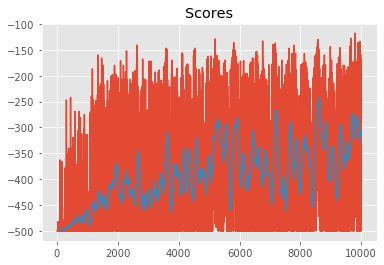

In [20]:
import pandas as pd
def plot_scores(scores, rolling_window=100):
    plt.plot(scores)
    plt.title('Scores')
    
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)